# COVID-19 Data Preprocessing

In this notebook, we preprocess views of the COVID-19 dataset to create input suitable for FACTM analysis. The source data is available [here](https://www.biorxiv.org/content/10.1101/2023.07.30.551145v1).

This notebook generates:
 - input to FACTM (`RPRA_CT12.pkl`),
 - `covid_expression.csv` (used in Figure 7B).

## Packages

In [10]:
import pandas as pd
import numpy as np
import scanpy as sc
import dill
from copy import deepcopy
import seaborn as sns

from sklearn.preprocessing import quantile_transform

from scipy.stats import zscore
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

### Cytokines

In [20]:
cytokines = pd.read_csv('data/cytokines_file13.csv')

In [21]:
cytokines = cytokines[cytokines['sample_origin'] == 'SERUM']
# cytokines = cytokines[cytokines['sample_origin'] == 'BAL']

In [22]:
cytokines_long = cytokines[['Subject_ID', 'display_name', 'mean_concentration']]
cytokines_wide = cytokines_long.pivot(index='Subject_ID', columns='display_name', values='mean_concentration')
cytokines_wide_nozero = cytokines_wide.loc[:,np.mean(np.abs(cytokines_wide), 0) > 0]

In [23]:
# the set of patients with both measured cytokine levels and scRNA-seq data is empty - we don't use cytokines
# cytokines_wide_nozero.head()

### Meta features

In [24]:
meta_1 = pd.read_csv('data/meta_file1.csv', index_col=0)
meta_2 = pd.read_csv('data/meta_file2.csv', index_col=0)

In [25]:
meta_1.insert(0, 'Study_ID', meta_1.index, True)
meta_1.insert(1, 'HV_RPRA', 'RPRA', True)
meta_2.insert(0, 'Study_ID', meta_2.index, True)
meta_2.insert(1, 'HV_RPRA', 'Healthy', True)

In [26]:
meta_1['Hispanic or Latino'] = meta_1['Ethnicity']
meta_1['Hispanic or Latino'] = meta_1['Hispanic or Latino'].replace('Not hispanic or latino', 'No')
meta_1['Hispanic or Latino'] = meta_1['Hispanic or Latino'].replace('Hispanic or latino', 'Yes')

In [27]:
clinical_feature_names = ['Study_ID', 'HV_RPRA', 'Sex', 'Age', 'Race', 'BMI', 'Hispanic or Latino']

In [28]:
meta_1 = meta_1[clinical_feature_names]
meta_2 = meta_2[clinical_feature_names]
meta = pd.concat([meta_1, meta_2])

In [29]:
meta.to_csv('FACTM_input/meta.csv')

### BAL - flow cytometry + CT1 + CT2

In [30]:
ct_1 = pd.read_csv('data/ct_1_file4.csv')
ct_2 = pd.read_csv('data/ct_2_file5.csv')
flow = pd.read_csv('data/flow_cytometry_file6.csv')

In [3]:
feature_names = [flow.columns[2:], ct_1.columns[1:], ct_2.columns[1:]]
with open('FACTM_input/feature_names.pkl', 'wb') as file:
    dill.dump(feature_names, file)

### BAL - scRNAseq count matrix with cell types annotations

In [2]:
adata_single_cell = sc.read_h5ad("data/integrated_BAL.h5ad")

In [3]:
gene_names = np.array(adata_single_cell.var.index)

In [4]:
with open('FACTM_input/gene_names.pkl', 'wb') as file:
    dill.dump(gene_names, file)

### Samples for the model

#### Patients IDs

We obtain subsets of patients for whom distinct data modalities are available: 

 (1) flow cytometry and scRNA-seq; 

 (2) flow cytometry, CT1 or CT2, and scRNA-seq; and 

 (3) flow cytometry, CT1, CT2, and scRNA-seq. 


CT scans are not available for healthy patients, only for RPRA.

 - RPRA - respiratory PASC with radiographic abnormalities
 - PASC - post-acute sequelae of COVID-19

##### Healthy and RPRA - flow cytometry & single cell RNAseq

In [31]:
study_id_list = np.sort(adata_single_cell.obs['Study_ID'].unique())

In [32]:
study_id_list = np.sort(flow[flow['Study_ID'].isin(study_id_list)].reset_index().dropna()['Study_ID'])

In [33]:
study_id_list_ds_HV_RPRA = deepcopy(study_id_list)

In [34]:
# rpra transplant delete
study_id_list_ds_HV_RPRA = np.delete(study_id_list_ds_HV_RPRA, 14, 0)
study_id_list = np.delete(study_id_list, 14, 0)

In [35]:
study_id_list_ds_HV_RPRA.shape, study_id_list.shape

((27,), (27,))

##### RPRA - ct1/ct1&ct2, flow cytometry & single cell RNAseq

In [36]:
study_id_list = np.sort(ct_1[ct_1['Subject_ID'].isin(study_id_list)].reset_index().dropna()['Subject_ID'])

In [37]:
study_id_list_ds_RPRA_CT1 = deepcopy(study_id_list)

In [38]:
study_id_list_ds_RPRA_CT1.shape, study_id_list.shape

((22,), (22,))

In [39]:
study_id_list = np.sort(ct_2[ct_2['Subject_ID'].isin(study_id_list)].reset_index().dropna()['Subject_ID'])

In [40]:
study_id_list_ds_RPRA_CT12 = deepcopy(study_id_list)

In [41]:
study_id_list_ds_RPRA_CT12.shape, study_id_list.shape

((20,), (20,))

In [42]:
len(study_id_list_ds_HV_RPRA), len(study_id_list_ds_RPRA_CT1), len(study_id_list_ds_RPRA_CT12)

(27, 22, 20)

## Single cell - preprocess data

In [5]:
def create_new_cell_type_column(cell_type):
    cell_type_v2 = cell_type

    cell_type_v2 = cell_type_v2.replace('CD4 T cells-1', 'CD4 T cells')
    cell_type_v2 = cell_type_v2.replace('CD4 T cells-2', 'CD4 T cells')

    cell_type_v2 = cell_type_v2.replace('CD8 T cells-1', 'CD8 T cells')
    cell_type_v2 = cell_type_v2.replace('CD8 T cells-2', 'CD8 T cells')
    cell_type_v2 = cell_type_v2.replace('CD8 T cells-3', 'CD8 T cells')

    cell_type_v2 = cell_type_v2.replace('MoAM-1', 'MoAM')
    cell_type_v2 = cell_type_v2.replace('MoAM-2', 'MoAM')
    cell_type_v2 = cell_type_v2.replace('MoAM-3', 'MoAM')
    cell_type_v2 = cell_type_v2.replace('MoAM-4', 'MoAM')

    cell_type_v2 = cell_type_v2.replace('Monocytes-1', 'Monocytes')
    cell_type_v2 = cell_type_v2.replace('Monocytes-2', 'Monocytes')

    cell_type_v2 = cell_type_v2.replace('TRAM-1', 'TRAM')
    cell_type_v2 = cell_type_v2.replace('TRAM-2', 'TRAM')
    cell_type_v2 = cell_type_v2.replace('TRAM-3', 'TRAM')
    cell_type_v2 = cell_type_v2.replace('TRAM-4', 'TRAM')
    cell_type_v2 = cell_type_v2.replace('TRAM-5', 'TRAM')
    cell_type_v2 = cell_type_v2.replace('TRAM-6', 'TRAM')
    cell_type_v2 = cell_type_v2.replace('TRAM-7', 'TRAM')

    return cell_type_v2

In [19]:
data_ctm_log = []
data_ctm = []
info = []

for study_id in study_id_list_ds_HV_RPRA:
    study_cell_indeces = adata_single_cell.obs['Study_ID'] == study_id
    study_array = np.array((adata_single_cell.X[study_cell_indeces,:]).todense())
    data_ctm_log.append(study_array)
    data_ctm.append(np.expm1(study_array))

    info_tmp = adata_single_cell.obs[adata_single_cell.obs['Study_ID'] == study_id]
    info_tmp = info_tmp.assign(cell_type_groups = np.array(create_new_cell_type_column(info_tmp['cell_type'])).tolist())

    info.append(info_tmp)

## Prepare FACTM input

In [20]:
m0 = flow[flow['Study_ID'].isin(study_id_list_ds_HV_RPRA)].iloc[:,2:]
m0 = quantile_transform(m0, n_quantiles=len(study_id_list_ds_HV_RPRA), output_distribution='normal')

In [21]:
factm_input_log = {
    'M0': m0,
    'M1': data_ctm_log
}
factm_input = {
    'M0': m0,
    'M1': data_ctm
}

In [22]:
with open('FACTM_input/HV_RPRA_log.pkl', 'wb') as file:
    dill.dump(factm_input_log, file)
with open('FACTM_input/HV_RPRA.pkl', 'wb') as file:
    dill.dump(factm_input, file)
with open('FACTM_input/HV_RPRA_info.pkl', 'wb') as file:
    dill.dump(info, file)
with open('FACTM_input/HV_RPRA_Study_ID.pkl', 'wb') as file:
    dill.dump(study_id_list_ds_HV_RPRA, file)

In [23]:
new_set = np.isin(study_id_list_ds_HV_RPRA, study_id_list_ds_RPRA_CT1)

In [24]:
data_ctm_log = [data_ctm_log[i] for i in range(len(data_ctm_log)) if new_set[i]]
data_ctm = [data_ctm[i] for i in range(len(data_ctm)) if new_set[i]]
info = [info[i] for i in range(len(info)) if new_set[i]]

In [25]:
m0 = flow[flow['Study_ID'].isin(study_id_list_ds_RPRA_CT1)].iloc[:,2:]
m0 = quantile_transform(m0, n_quantiles=len(study_id_list_ds_RPRA_CT1), output_distribution='normal')

In [26]:
m1 = ct_1[ct_1['Subject_ID'].isin(study_id_list_ds_RPRA_CT1)].iloc[:,1:]
m1 = quantile_transform(m1, n_quantiles=len(study_id_list_ds_RPRA_CT1), output_distribution='normal')

In [27]:
factm_input_log = {
    'M0': m0,
    'M1': m1,
    'M2': data_ctm_log
}
factm_input = {
    'M0': m0,
    'M1': m1,
    'M2': data_ctm
}

In [28]:
with open('FACTM_input/RPRA_CT1_log.pkl', 'wb') as file:
    dill.dump(factm_input_log, file)
with open('FACTM_input/RPRA_CT1.pkl', 'wb') as file:
    dill.dump(factm_input, file)
with open('FACTM_input/RPRA_CT1_info.pkl', 'wb') as file:
    dill.dump(info, file)
with open('FACTM_input/RPRA_CT1_Study_ID.pkl', 'wb') as file:
    dill.dump(study_id_list_ds_RPRA_CT1, file)

In [29]:
new_set = np.isin(study_id_list_ds_RPRA_CT1, study_id_list_ds_RPRA_CT12)

In [30]:
data_ctm_log = [data_ctm_log[i] for i in range(len(data_ctm_log)) if new_set[i]]
data_ctm = [data_ctm[i] for i in range(len(data_ctm)) if new_set[i]]
info = [info[i] for i in range(len(info)) if new_set[i]]

In [31]:
m0 = flow[flow['Study_ID'].isin(study_id_list_ds_RPRA_CT12)].iloc[:,2:]
m0 = quantile_transform(m0, n_quantiles=len(study_id_list_ds_RPRA_CT12), output_distribution='normal')

In [32]:
m1 = ct_1[ct_1['Subject_ID'].isin(study_id_list_ds_RPRA_CT12)].iloc[:,1:]
m1 = quantile_transform(m1, n_quantiles=len(study_id_list_ds_RPRA_CT12), output_distribution='normal')

In [33]:
m2 = ct_2[ct_2['Subject_ID'].isin(study_id_list_ds_RPRA_CT12)].iloc[:,1:]
m2 = quantile_transform(m2, n_quantiles=len(study_id_list_ds_RPRA_CT12), output_distribution='normal')

In [34]:
factm_input_log = {
    'M0': m0,
    'M1': m1,
    'M2': m2,
    'M3': data_ctm_log
}
factm_input = {
    'M0': m0,
    'M1': m1,
    'M2': m2,
    'M3': data_ctm
}

In [35]:
with open('FACTM_input/RPRA_CT12_log.pkl', 'wb') as file:
    dill.dump(factm_input_log, file)
with open('FACTM_input/RPRA_CT12.pkl', 'wb') as file:
    dill.dump(factm_input, file)
with open('FACTM_input/RPRA_CT12_info.pkl', 'wb') as file:
    dill.dump(info, file)
with open('FACTM_input/RPRA_CT12_Study_ID.pkl', 'wb') as file:
    dill.dump(study_id_list_ds_RPRA_CT12, file)

## Z-scored mean gene expression

In [65]:
new_celltypes_all_data = create_new_cell_type_column(adata_single_cell.obs.cell_type)
cell_type_list = np.unique(new_celltypes_all_data)
topic_mean_distribution_cell_type_log = np.zeros((len(cell_type_list), 1000))

In [66]:
for i in range(len(cell_type_list)):
    ind_tmp = np.array((new_celltypes_all_data == cell_type_list[i]))
    if ind_tmp.sum() > 0:
        topic_mean_distribution_cell_type_log[i,:] = np.array(np.mean(adata_single_cell.X[ind_tmp, :], axis=0)[0,:])
    else:
        topic_mean_distribution_cell_type_log[i,:] = np.nan

In [67]:
topics_scaled = scale(topic_mean_distribution_cell_type_log[:,:], axis=0).T

/home/gosia/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1500x1200 with 0 Axes>

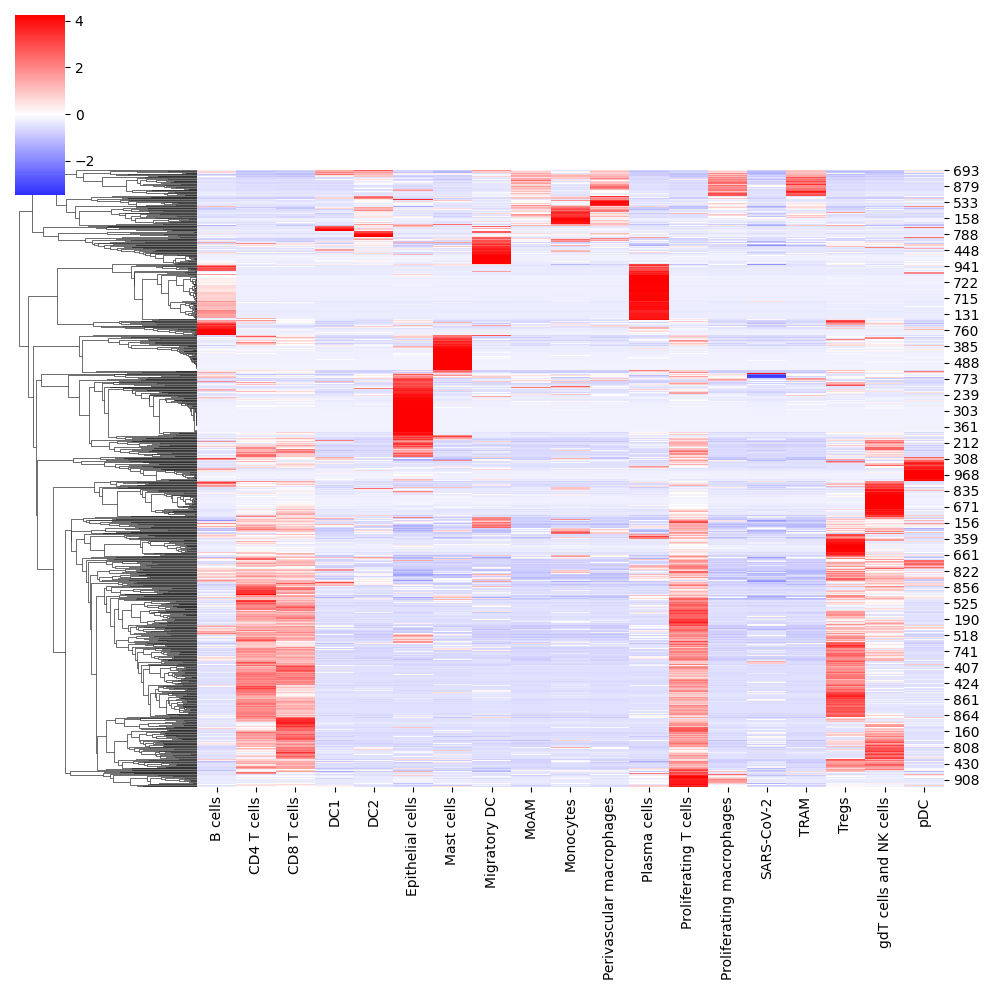

In [68]:
plt.figure(figsize=(15,12))
res = sns.clustermap(topics_scaled, center=0, cmap="bwr", xticklabels=cell_type_list, col_cluster=False)
plt.show()

In [15]:
df = pd.DataFrame(topics_scaled)
df.columns = cell_type_list
df.index = gene_names

In [ ]:
# df.to_csv('gene_expression_z_score.csv')